# Part 1

## Pywr-STARFIT Validation

The first part of this notebook checks the performance of the pywr-implemented STARFIT reservoir operations with a direct, explicit STARFIT simulator.  

Results from a Pywr model run will be loaded; the inflow data for the same period is then used as input for the explicit STARFIT simulator. The resulting simulated storages and releases are compared to one another. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

In [2]:
# Import explicit STARFIT simulator
from simulate_reservoir_daily import starfit_reservoir_simulation as starfit_sim

In [3]:
### Load pywr model results
with h5py.File('../output_data/drb_output.hdf5', 'r') as f:
    keys = list(f.keys())
    pywr_results = pd.DataFrame({keys[0]: f[keys[0]][:,2]})
    for k in keys[1:]:
        if 'catchment' in k or 'outflow' in k or 'reservoir' in k or 'delLordville' in k or 'delMontague' in k:
            pywr_results[k] = f[k][:,2]
    day = [f['time'][i][0] for i in range(len(f['time']))]
    month = [f['time'][i][2] for i in range(len(f['time']))]
    year = [f['time'][i][3] for i in range(len(f['time']))]
    date = [f'{y}-{m}-{d}' for y,m,d in zip(year, month, day)]
    date = pd.to_datetime(date)
    pywr_results.index = date
    
# Check    
pywr_results.head()

,catchment_assunpink,catchment_beltzvilleCombined,catchment_blueMarsh,catchment_cannonsville,catchment_delLordville,catchment_delMontague,catchment_delTrenton,catchment_fewalter,catchment_greenLane,catchment_hopatcong,...,reservoir_merrillCreek,reservoir_mongaupeCombined,reservoir_neversink,reservoir_nockamixon,reservoir_ontelaunee,reservoir_pepacton,reservoir_prompton,reservoir_shoholaMarsh,reservoir_stillCreek,reservoir_wallenpaupack
2005-10-01,4.165516,6.167736,56.075708,54.789476,206.148278,346.418111,1246.526961,0.827954,19.824916,6.576289,...,7480.060999,13527.777032,22222.666299,11341.419289,1867.484961,98479.381724,1866.388134,4144.303915,1869.578008,43314.112593
2005-10-02,3.576119,3.580008,55.332976,59.702258,186.498366,310.564656,1240.020397,0.662540,16.525164,6.468654,...,7470.843195,12867.094491,22226.482625,11112.040186,1846.108356,97734.309826,1843.859658,3981.978740,1850.292512,42686.665936
2005-10-03,3.348265,3.323924,54.625300,61.305131,173.877297,279.458524,1182.329152,0.635704,15.891035,6.370124,...,7461.623437,12205.769678,22226.607031,10882.612462,1824.701484,96982.194197,1821.269971,3819.212515,1830.978035,42107.443967
2005-10-04,3.145459,3.250732,53.934031,52.703100,164.711205,263.954519,1132.108234,0.620010,15.653195,6.273139,...,7452.401775,11544.066193,22223.996537,10653.137354,1803.265047,97023.470965,1798.622646,3656.030987,1811.634923,41572.733310
2005-10-05,2.954964,3.181903,53.257477,46.755163,155.326508,247.127204,1105.863016,0.605192,15.545852,6.177617,...,7443.178249,10881.997214,22219.224585,10423.615881,1781.799675,96258.793756,1775.920636,3492.455435,1792.263503,41079.104423


In [4]:
### Load STARFIT conus data for reservoirs in DRB
starfit = pd.read_csv('../model_data/drb_model_istarf_conus.csv')
reservoirs = [res for res in starfit['reservoir']]
reservoir_ids = [id for id in starfit['GRanD_ID']]
reservoir_names = [name for name in starfit['GRanD_NAME']]

In [5]:
# Simulation time period
start_date = '2005-10-01'
end_date = '2012-10-01'

# Specify the reservoirs to assess
reservoir = 'blueMarsh'
gage = '01470960'

In [8]:
# Pull specific range and scale
pywr_inflow = pywr_results[f'catchment_{reservoir}']
pywr_Si = pywr_results[f'reservoir_{reservoir}'][0]
pywr_storage = pywr_results[f'reservoir_{reservoir}']
pywr_outflow = pywr_results[f'outflow_{reservoir}']

In [10]:
# Run explicit STARFIT simulation 
starfit_results = starfit_sim(starfit, reservoir, pywr_inflow, pywr_Si)

starfit_results.head()

,storage,outflow
0,20661.106402,555.146506
1,20162.035605,555.146506
2,19662.222075,555.146506
3,19161.700869,555.146506
4,18660.488394,555.146506


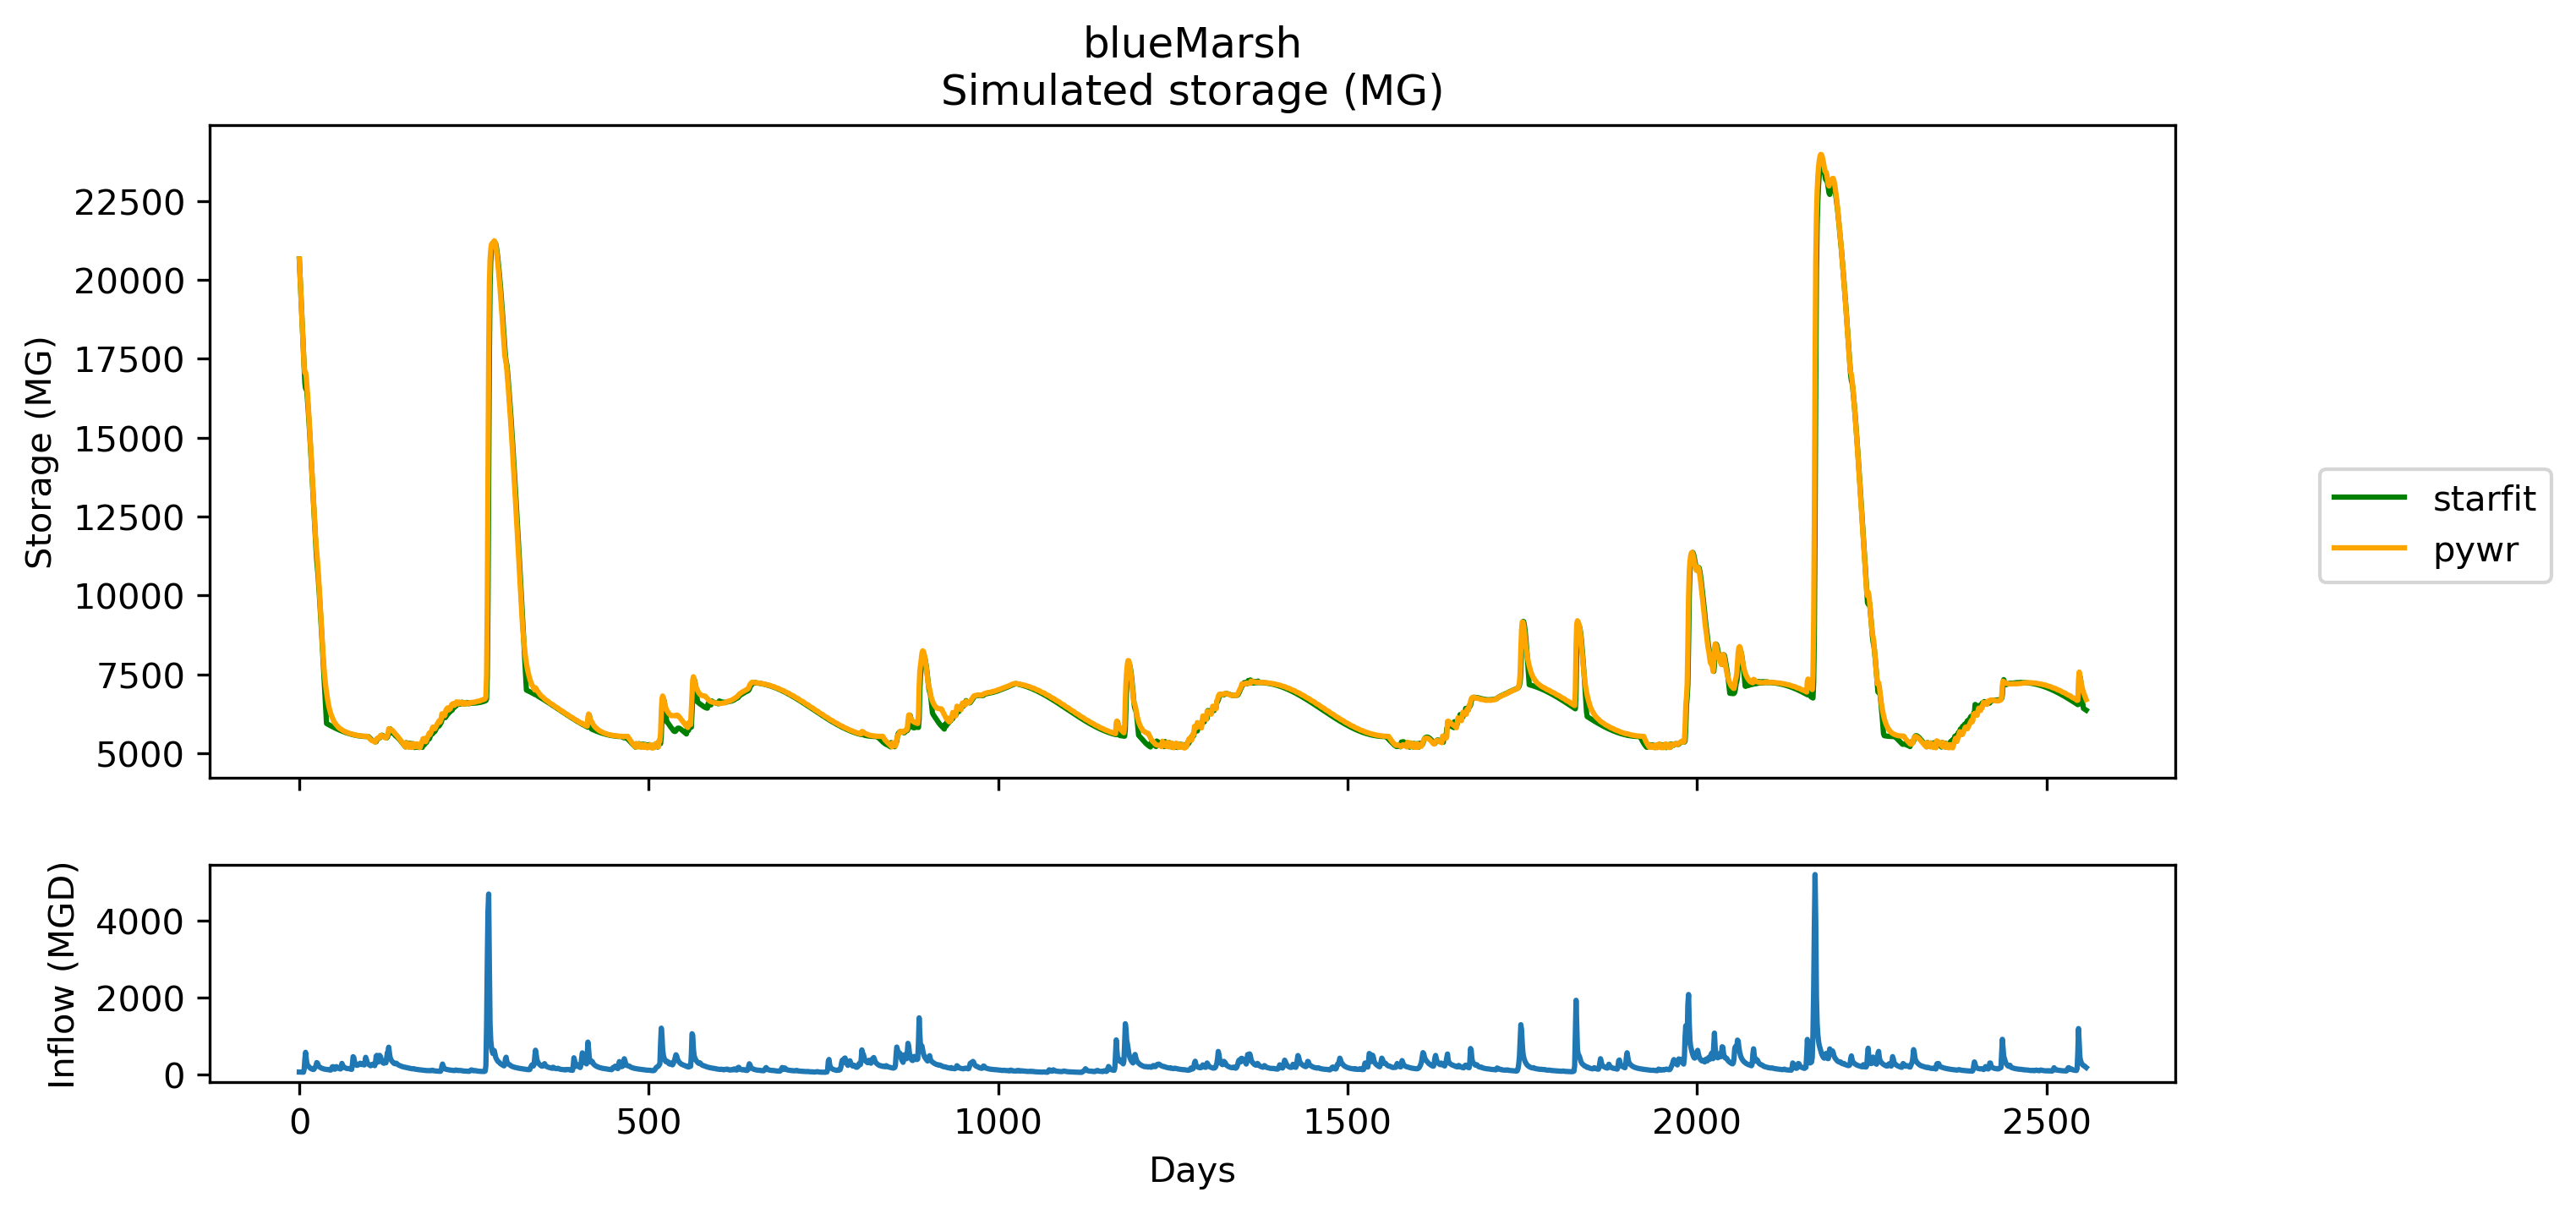

In [11]:
### PLotting

t = range(len(pywr_inflow))

# Plot comparison of simulated storage
fig,axs = plt.subplots(2, 1, figsize = (10,5), gridspec_kw={'height_ratios': [3, 1]}, dpi = 300)
ax = axs[0]
ax.plot(t, starfit_results['storage'], label = 'starfit', color = 'green')
ax.plot(t, pywr_storage, label = 'pywr', linestyle = '-', color = 'orange')
ax.set_title(f'{reservoir}\nSimulated storage (MG)')
ax.set_ylabel('Storage (MG)')
ax.legend(bbox_to_anchor = (1.2, 0.5))
ax.set_xticklabels([])
ax = axs[1]
ax.plot(t, pywr_inflow, label = 'Inflow')
ax.set_xlabel('Days')
ax.set_ylabel('Inflow (MGD)')
plt.show()

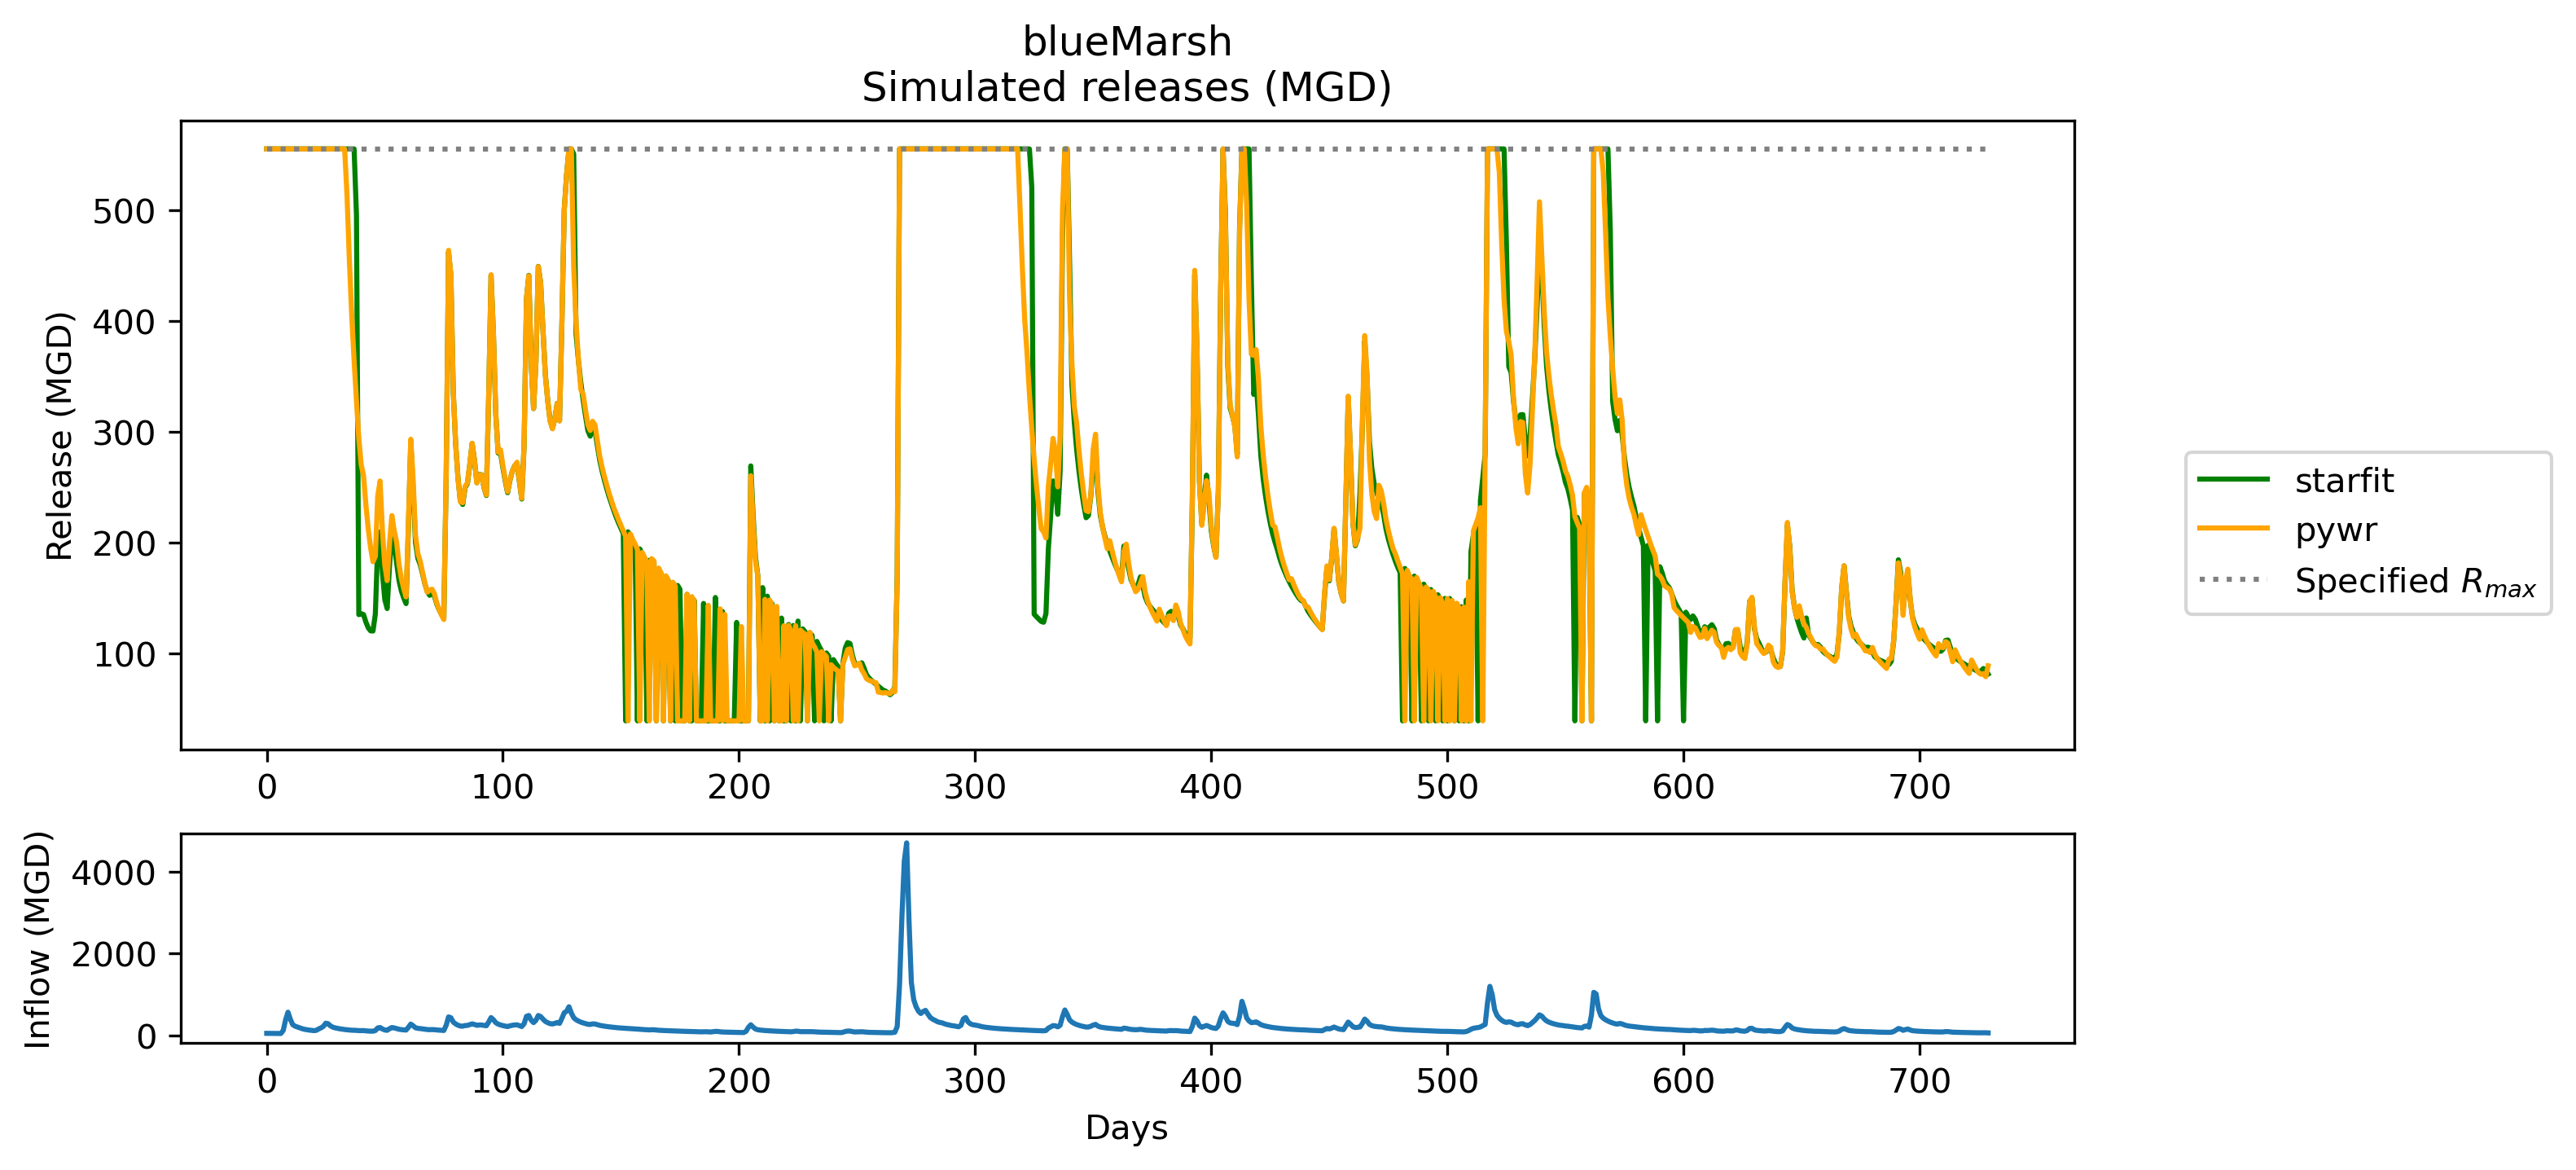

In [12]:
# Plot comparison of simulated outflows (zoomed in to show detail)

fig,axs = plt.subplots(2, 1, figsize = (10,5), gridspec_kw={'height_ratios': [3, 1]}, dpi = 300)
ax = axs[0]
ax.plot(t[0:730], starfit_results['outflow'][0:730], label = 'starfit', color = 'green')
ax.plot(t[0:730], pywr_outflow[0:730], label = 'pywr', color = 'orange')
ax.plot(t[0:730], np.ones(730)*555, label = 'Specified $R_{max}$', color = 'grey', linestyle = ':')
ax.set_title(f'{reservoir}\nSimulated releases (MGD)')
ax.set_ylabel('Release (MGD)')
ax.legend(bbox_to_anchor = (1.05, 0.5))
ax = axs[1]
ax.plot(t[0:730], pywr_inflow[0:730], label = 'Inflow')
ax.set_xlabel('Days')
ax.set_ylabel('Inflow (MGD)')
plt.show()

# Part 2

Now that the Pywr implementation of STARFIT appears to match the explicit STARFIT simulation, we can assume that the reservoir rules are programmed acurately in the model.  

**Part 2** of this notebook explores the differences in data available. The following are considered:

ResOpsUS data 
> This data was sourced from ACE, and is only available for Beltzville and Blue Marsh.  

USGS data
> The nearest down-stream gages for each dam.

Scaled NHM data 
> NHM unmanaged streamflows upstream of the dam, scaled according to the GRanD database average inflow. 

Before this section will work, the USGS and ResOpsUS data needs to be available in the proper directories.  The USGS data is generated by running the ```process_usgs_data.py``` script in the **./usgs_data/** directory. 

The ResOpsUS data is produced using the ```get_ResOps_data.py``` script in the **./ResOpsUS_data/** directory, after the *DAILY_AV_INFLOW_CUMECS, DAILY_AV_OUTFLOW_CUMECS, and DAILY_AV_STORAGE_MCM* csv files have been made available from the ResOpsUS database. 


In [14]:
### Load USGS data
usgs_data = pd.read_csv(f'./usgs_data/clean_usgs_{gage}.csv')

### Load ResOpsUS outlfow data
resops_data = pd.read_csv(f'./ResOpsUS_data/resops_{reservoir}.csv', sep = ',')

In [15]:
# Find index corresponding to pywr range
start_index = [i for i,x in enumerate(resops_data['date'] == start_date) if x][0]
end_index = [i for i,x in enumerate(resops_data['date'] == end_date) if x][0]

In [16]:
# Find ResOpsUS inflow corresponding to PYWR simulation period & scale
resops_inflow = resops_data['inflow'][start_index:end_index + 1].values*22.824
resops_outflow = resops_data['outflow'][start_index:end_index + 1].values*22.824
resops_inflow[resops_inflow < 0] = 0
resops_outflow[resops_outflow < 0] = 0

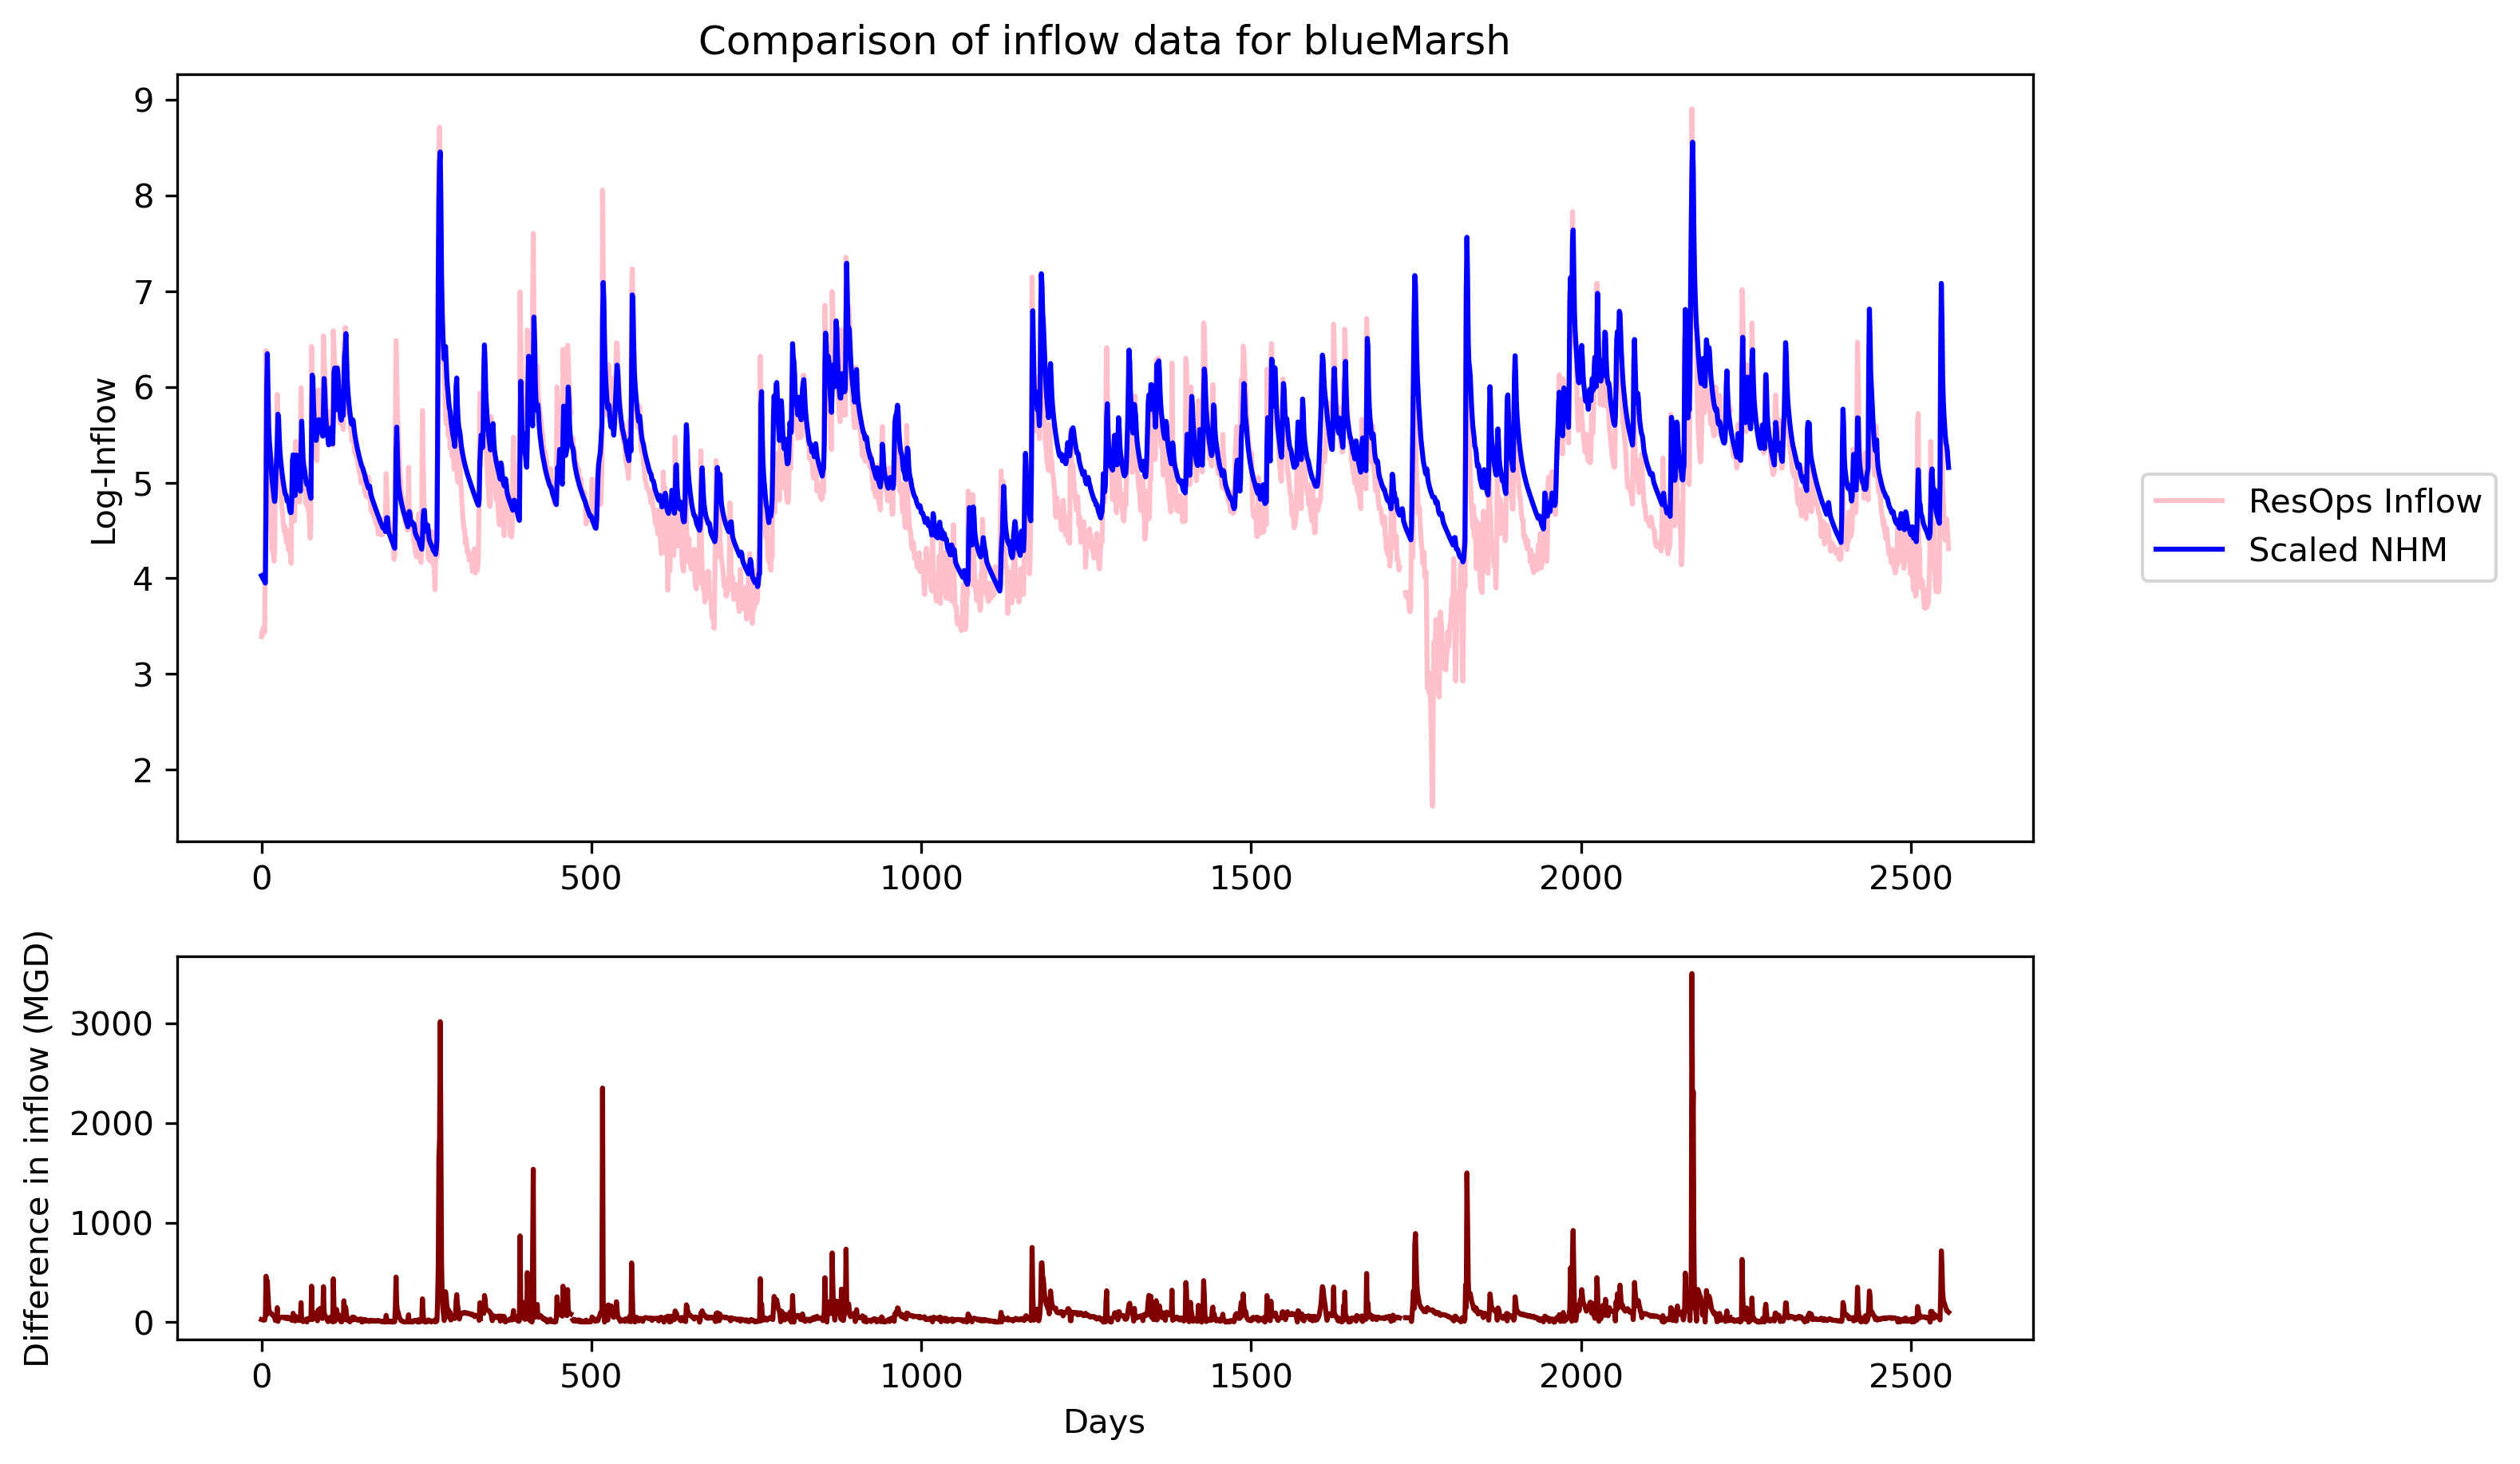

In [17]:
# Plot comparison of inflow timeseries
fig,axs = plt.subplots(2, 1, figsize = (10,7), gridspec_kw={'height_ratios': [2, 1]}, dpi = 300)
ax = axs[0]
ax.plot(t, np.log(resops_inflow), color = 'pink', label = 'ResOps Inflow')
ax.plot(t, np.log(pywr_inflow), color = 'blue', label = 'Scaled NHM')
ax.set_title(f'Comparison of inflow data for {reservoir}')
ax.set_ylabel('Log-Inflow')
ax.legend(bbox_to_anchor = (1.05, 0.5))
ax = axs[1]
ax.plot(t, abs(resops_inflow - pywr_inflow), color = 'maroon')
ax.set_ylabel('Difference in inflow (MGD)')
ax.set_xlabel('Days')
plt.show()

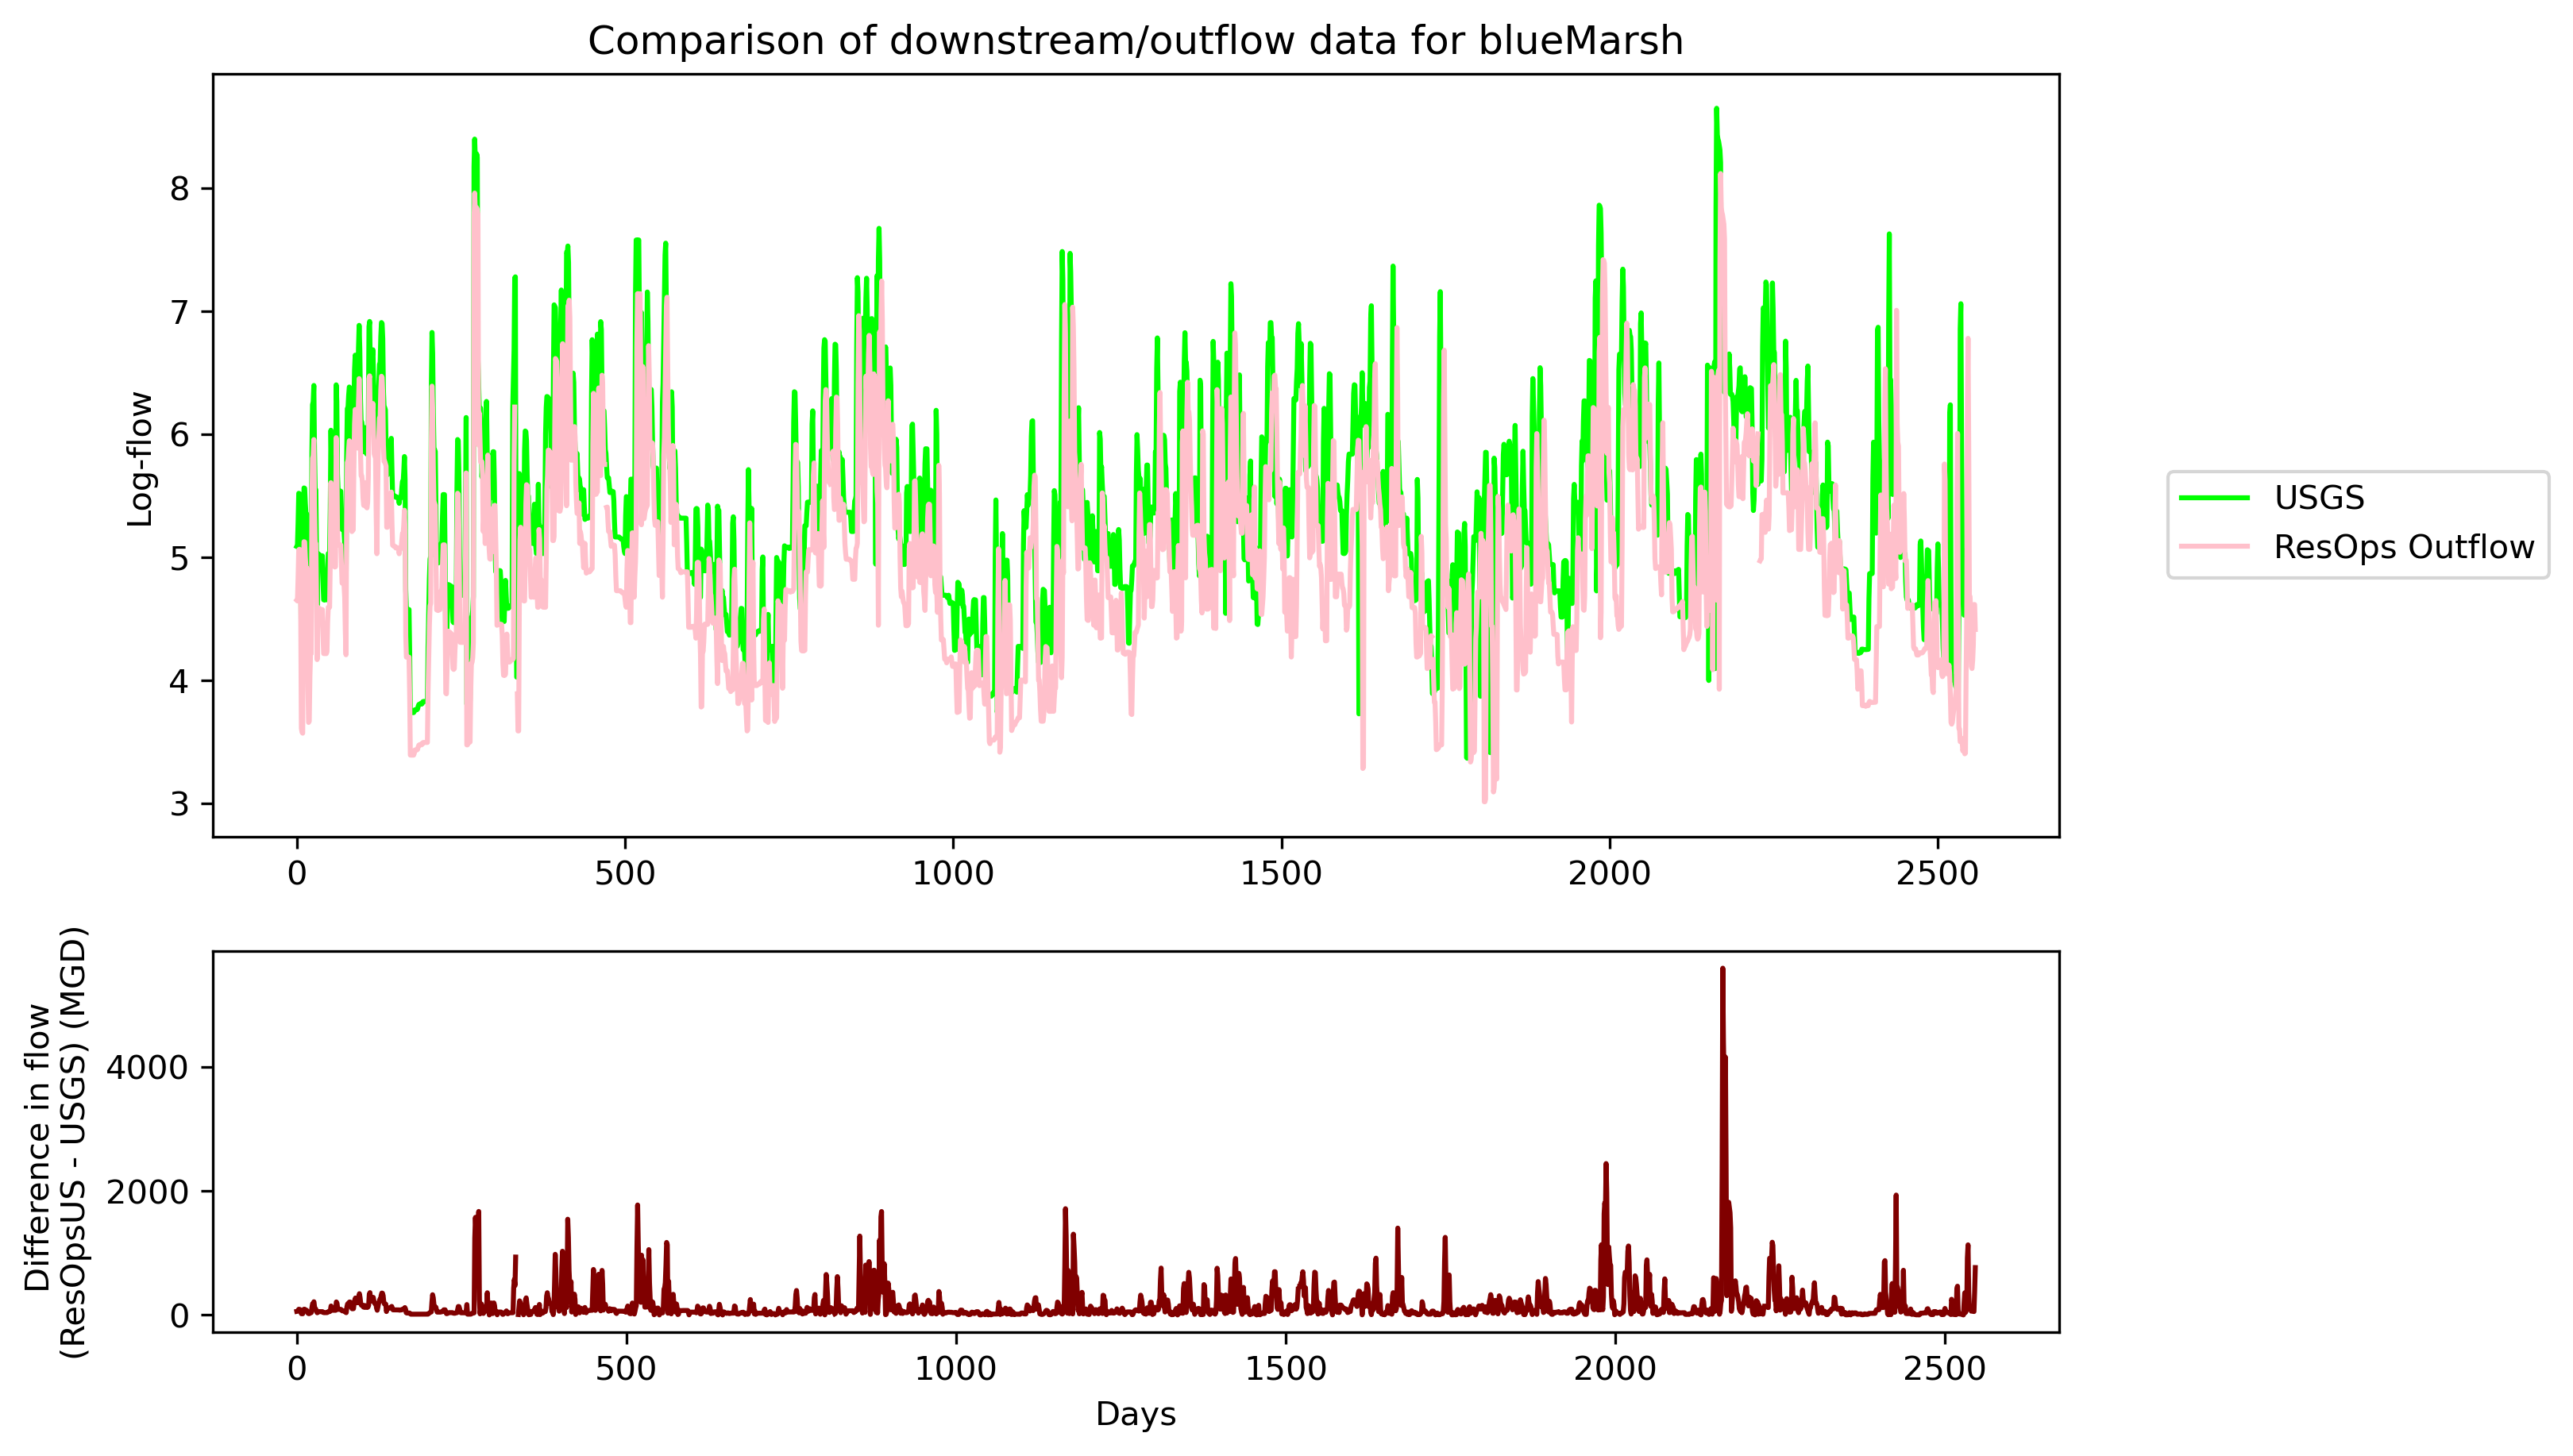

In [36]:
# Plot comparison of inflow timeseries
t = range(len(pywr_inflow))

fig,axs = plt.subplots(2, 1, figsize = (10,7), gridspec_kw={'height_ratios': [2, 1]}, dpi = 300)
ax = axs[0]
#ax.plot(t, np.log(pywr_outflow), color = 'blue', label = 'Scaled NHM')
ax.plot(range(len(usgs_data['flow'])), np.log(usgs_data['flow']), label = 'USGS', color = 'lime')
ax.plot(t, np.log(resops_outflow), color = 'pink', label = 'ResOps Outflow')
ax.set_title(f'Comparison of downstream/outflow data for {reservoir}')
ax.set_ylabel('Log-flow')
ax.legend(bbox_to_anchor = (1.05, 0.5))

ax = axs[1]
t = len(usgs_data['flow'])
ax.plot(range(t), abs(resops_outflow[0:t] - usgs_data['flow']), color = 'maroon')
ax.set_ylabel('Difference in flow \n(ResOpsUS - USGS) (MGD)')
ax.set_xlabel('Days')
plt.show()

TypeError: 'int' object is not subscriptable

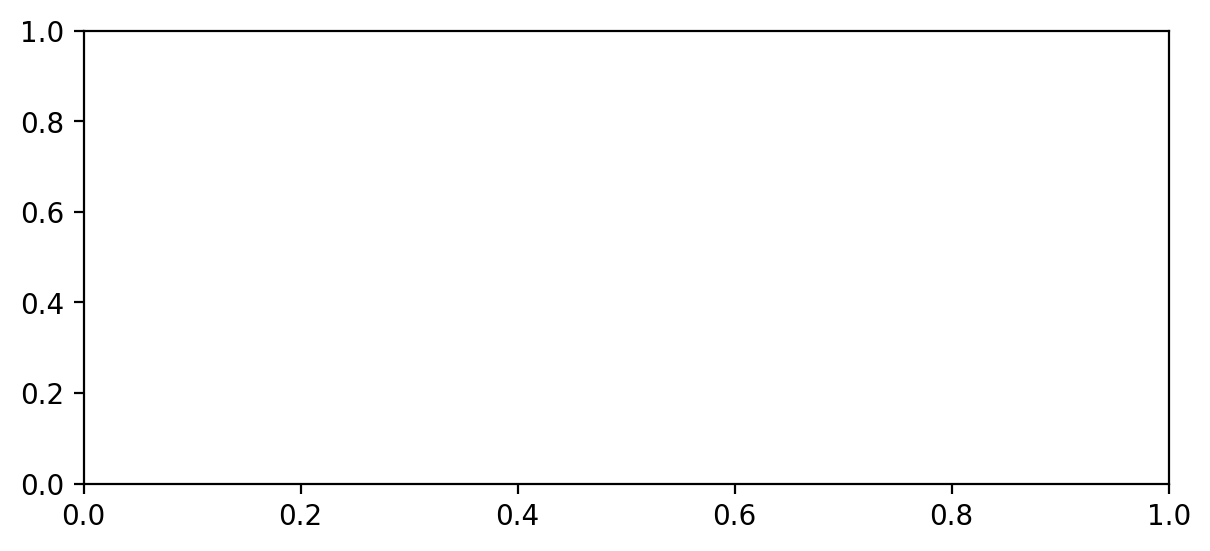

array([0.94973356, 0.83377078, 0.78827647, 0.94862006, 0.91052255,
       0.78668576, 0.77674382, 0.77252843, 0.80991012, 1.        ])